<a href="https://colab.research.google.com/github/aruaru0/SegFormer-test-codes/blob/main/SegFormer_blog_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install git+https://github.com/huggingface/accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-x__fc6l3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-

In [2]:
from datasets import load_dataset
# データセットをロード。高速化のために一部だけを利用
ds = load_dataset("scene_parse_150", split="train[:50]")
ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 50
})

In [3]:
ds = ds.train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

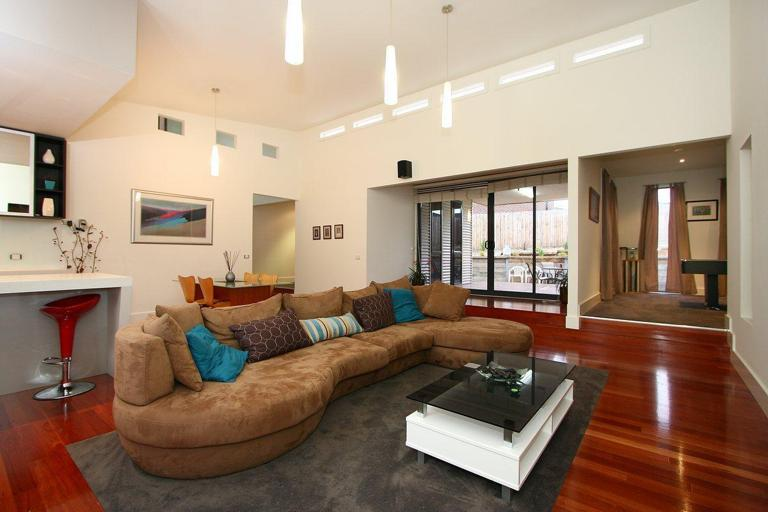

In [4]:
train_ds[0]["image"]

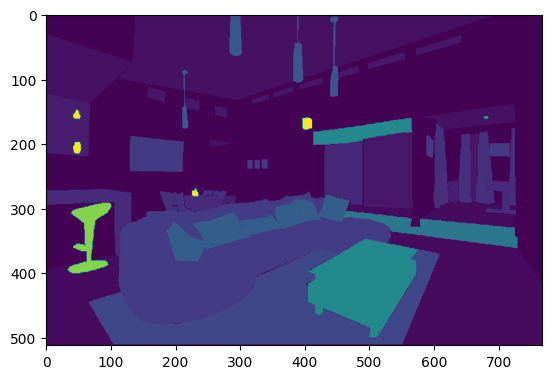

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_ds[0]["annotation"])

In [6]:
# 150種類のラベルのラベル名とIDの対応
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:659: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [7]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, reduce_labels=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


  0%|          | 0/1 [00:00<?, ?it/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [9]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

In [10]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [11]:
import evaluate

metric = evaluate.load("mean_iou")

In [12]:
import numpy as np
import torch
from torch import nn

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [13]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="./",
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
20,4.892000,4.938264,0.006174,0.035964,0.114047,"[0.35652766048100554, 0.0001089674474088688, 0.0, 0.13603360170581963, 0.0, 0.08394854612785306, 0.0, 0.013190844636667311, 0.0, 0.0, 0.0, 0.0034873198402012935, 0.027438309404070146, 0.0, 0.015566900241756354, 0.016624352740364615, 0.061977653631284914, 0.0, 0.0, 0.0, 0.005959591065458598, 0.0, 0.03431167520011538, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015197568389057751, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0012372386048806407, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, 0.00019199449174423685, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0]","[0.45662569886841176, 0.00011704408249759751, 0.0, 0.18621474897305731, 0.0, 0.17254925010530853, 0.0, 0.016864492024716196, 0.0, 0.0, 0.0, 0.004462646518853269, 0.028362490404428103, nan, 0.37713691095584956, 0.04224068809680006, 0.260765325310267, 0.0, nan, nan, 0.01617995264404104, 0.0, 0.13967005225151177, nan, 0.0, 0.0, nan, nan, 0.0, nan, nan, 0.0, 0.0, 0.0, nan, nan, 0.01874573960463531, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, nan, 0.0012570564827096894, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, nan, 0.005086826872478512, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan]"
40,4.614100,4.712105,0.014559,0.077828,0.242864,"[0.4529771776570673, 0.010234333975144408, 0.0024222306950456413, 0.23858808309198629, 0.0, 0.19623464386726255, 0.0426080393636729, 0.21429310670213866, 0.03000252218375255, 0.0, 0.0, 0.0002647221620580945, 0.07577859745299087, nan, 0.015238341448001494, 0.0226980927999502, 0.1240358867553155, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04808254880059571, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, 0.026003210272873195, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, nan, 0.0, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, 7.947862025115244e-05, nan, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0]","[0.6574003922189605, 0.011525762018579208, 0.0024222306950456413, 0.612542225744966, 0.0, 0.6232599602276624, 0.07416569985668464, 0.4046558413565167, 0.08724205753908724, 0.0, 0.0, 0.00031069058042649346, 0.09047445894441976, nan, 0.31544522075219267, 0.10631241344121292, 0.509543061301241, 0.0, nan, nan, 0.0, 0.0, 0.21229378265719487, nan, 0.0, 0.0, nan, nan, 0.0, nan, nan, 0.0, 0.0, 0.0, nan, nan, 0.027607361963190184, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.35652766048100554, 0.0001089674474088688, 0.0, 0.13603360170581963, 0.0, 0.08394854612785306, 0.0, 0.013190844636667311, 0.0, 0.0, 0.0, 0.0034873198402012935, 0.027438309404070146, 0.0, 0.015566900241756354, 0.016624352740364615, 0.061977653631284914, 0.0, 0.0, 0.0, 0.005959591065458598, 0.0, 0.03431167520011538, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015197568389057751, nan, 0.0, 0.0, nan, 0.

TrainOutput(global_step=1000, training_loss=2.3375079669058323, metrics={'train_runtime': 1038.9316, 'train_samples_per_second': 1.925, 'train_steps_per_second': 0.963, 'total_flos': 3.5414863773696e+16, 'train_loss': 2.3375079669058323, 'epoch': 50.0})

In [15]:
trainer.save_model("./trained-model")

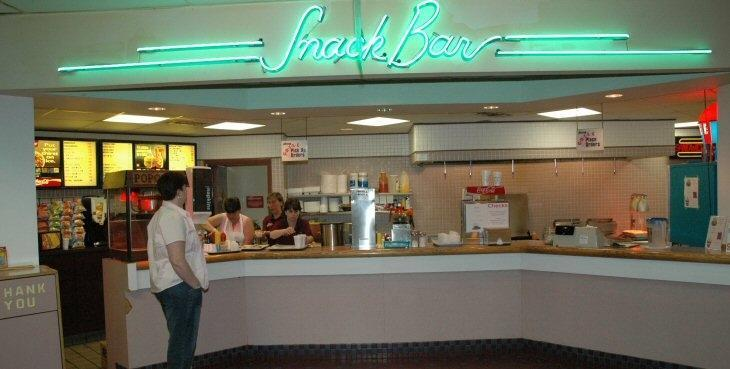

In [16]:
ds = load_dataset("scene_parse_150", split="train[:50]")
image = ds[0]["image"]
image

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSemanticSegmentation.from_pretrained("./trained-model", id2label=id2label, label2id=label2id)
model = model.to(device)
checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [18]:
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

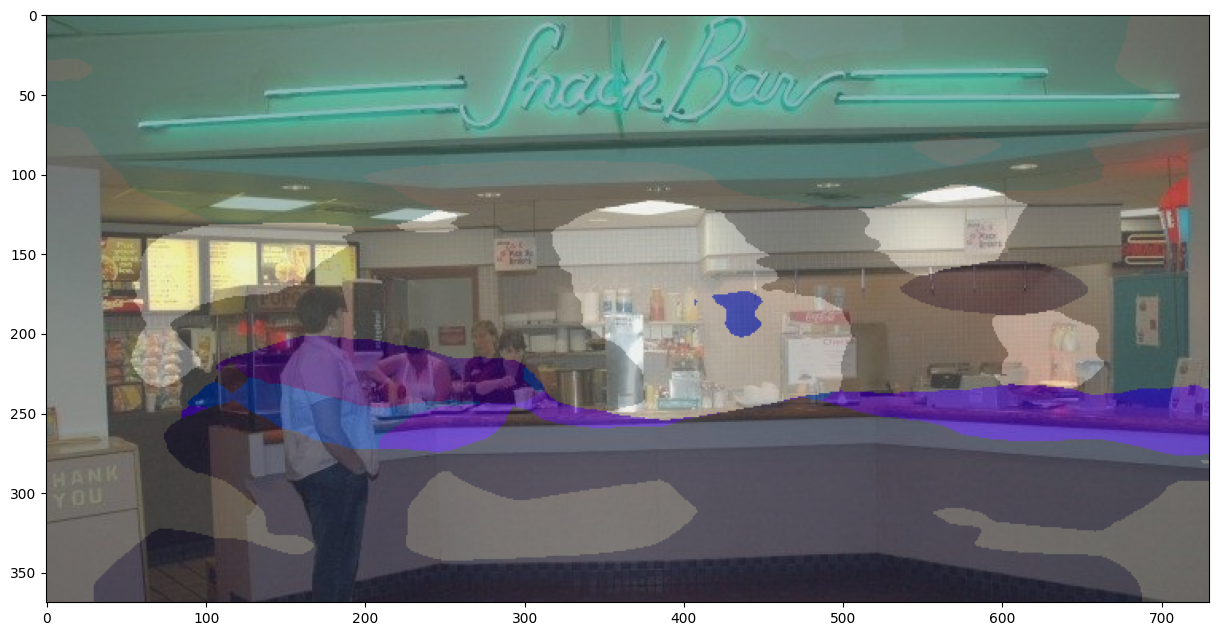

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]


color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()